<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/SocialAds/redwinequality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/cesar-claros/synergistic
% cd synergistic/

Cloning into 'synergistic'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 298 (delta 138), reused 49 (delta 16), pack-reused 0
Receiving objects: 100% (298/298), 20.77 MiB | 9.16 MiB/s, done.
Resolving deltas: 100% (138/138), done.
/content/synergistic


In [2]:
#%%
# Command line instalation
# ---------------------------
# ! pip install torch
! pip install gpytorch

# Imports
# ---------------------------
import io #Used as buffer
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.funcs as sgn
import auxfunc.trustscore as trs
import seaborn as sns
import torch
import tensorflow as tf
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, decomposition,\
     tree, neighbors, discriminant_analysis, gaussian_process, preprocessing
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
import os
import random

     |████████████████████████████████| 310 kB 2.3 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=7f42504d0b9575d1f7c5bf63acb6a912bc3a6cc7315120a72affa87055142d4d
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [3]:
#%%
# MODELS
# ====================
# Grid search for parameters and classifiers

models = { 
        'predictor':
            [
            svm.SVC(),
            gaussian_process.GaussianProcessClassifier(),
            linear_model.LinearRegression(),
            linear_model.Lasso(),
            svm.SVR()],
        'name':
            [
            'SVM',
            'GPClassifier',
            'LinReg',
            'Lasso',
            'SVR']}
parameters = [
            {'SVM__kernel':['poly'],'SVM__degree':[3,4,5]},
            {'GPClassifier__kernel':[]},
            {},
            {'Lasso__alpha':np.linspace(0.01,1,10)},
            {'SVR__kernel':['linear'], 'SVR__C':np.logspace(-1, 1, 10), 'SVR__epsilon':np.logspace(-2, 2, 10)} ]

In [4]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False), rho_grid=[0.1, 0.15])
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [5]:
#%%
# Initialize model
def init_model(input_dim, models, parameters, clf_name):
    i = np.nonzero(np.array(models['name'])==clf_name)[0].squeeze()
      
    scaler = preprocessing.StandardScaler()
    steps = [('scaler', scaler), (models['name'][i], models['predictor'][i])]
    ppline = pipeline.Pipeline(steps) # define the pipeline object.

    clf = model_selection.GridSearchCV(ppline, param_grid=parameters[i], cv=5)
    return clf

In [6]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    if hasattr(model, "decision_function"):
      y_pred_soft = model.best_estimator_.decision_function(X)[:,None]
    elif hasattr(model, "predict_proba"):
      y_pred_soft = model.best_estimator_.predict_proba(X)
    else:
      y_pred_soft = model.best_estimator_.predict(X)[:,None]
    y_pred_th = model.best_estimator_.predict(X) 
    return y_pred_soft, y_pred_th

In [ ]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [ ]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [7]:
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data
# -------------
wine = pd.read_csv("datasets/winequality-red.csv",sep=';')
Data_X = wine.drop('quality',axis = 1)
Data_y = wine.quality
Data_X = Data_X.to_numpy()
Data_y_ns = Data_y.to_numpy() # not shifted Y labels
Data_y = Data_y_ns-Data_y_ns.min() # shifted labels
n_cat_set  = np.unique(Data_y, return_counts=False)
n_cat  = n_cat_set.size
# For reproducibility
tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)
#%%

In [21]:
# Assign labels
report_table = []
report_criteria = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
clf = 'SVR'
addPredictions = True
applyPCA = True
accuracy = 0
for sample, test in kf.split(Data_X):
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], models=models, parameters=parameters, clf_name=clf)
    model.fit(X_train, y_train)

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    # print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    X_train_GP = X_train
    X_val_GP = X_val
    X_test_GP = X_test

    if addPredictions:
          # Add predictions
          X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
          X_val_GP = np.concatenate((X_val, y_val_pred_soft), axis=1)
          X_test_GP = np.concatenate((X_test, y_test_pred_soft), axis=1)

    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)

    if applyPCA:
          pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
          # Apply PCA transform to all sets
          X_train_GP = pca_GP.transform(X_train_GP)
          X_val_GP = pca_GP.transform(X_val_GP)
          X_test_GP = pca_GP.transform(X_test_GP)
    
    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP,\
                                   y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th,\
                                   kernel='RBF', norm='labs')
    report_table.append(table)

    # Trust Score fitted on train data to evaluate loss reduction on val-test data
    trust_model = trs.TrustScore()
    trust_model.fit(X=X_train_GP,Y=y_train,classes=n_cat)
    trust_val,class_val   = trust_model.score(X_val_GP, y_val_pred_th.round().astype(int)) # y_val_pred_th
    trust_test,class_test = trust_model.score(X_test_GP, y_test_pred_th.round().astype(int)) # y_test_pred_th
    
    # # Baseline for comparison
    # crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    # report_criteria.append(crit_table)

    # if accuracy < model.best_estimator_.score(X_val,y_val):
    #     accuracy = model.best_estimator_.score(X_val,y_val)
    #     classifier = model.best_estimator_
    #     X_test_surface_plot = X_test
    #     y_test_surface_plot = y_test
    #     X_train_surface_plot = X_train
    #     y_train_surface_plot = y_train
    #     X_val_surface_plot = X_val
    #     y_val_surface_plot = y_val
    #     scaler_surface_plot = scaleX_GP
    #     exp_surface_plot = exp
    #     table_surface_plot = table

    del(model)


initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.493  noise: 0.099
Iter 492/500 - Loss: 0.502  noise: 0.099
Iter 493/500 - Loss: 0.503  noise: 0.099
Iter 494/500 - Loss: 0.490  noise: 0.099
Iter 495/500 - Loss: 0.495  noise: 0.099
Iter 496/500 - Loss: 0.498  noise: 0.099
Iter 497/500 - Loss: 0.490  noise: 0.098
Iter 498/500 - Loss: 0.489  noise: 0.098
Iter 499/500 - Loss: 0.493  noise: 0.098
Iter 500/500 - Loss: 0.497  noise: 0.098
evaluating with cuda...
evaluating with cuda...
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.494  noise: 0.101
Iter 492/500 - Loss: 0.495  noise: 0.101
Iter 493/500 - Loss: 0.498  noise: 0.101
Iter 494/500 - Loss: 0.495  noise: 0.101
Iter 495/500 - Loss: 0.487  noise: 0.101
Iter 496/500 - Loss: 0.497  noise: 0.101
Iter 497/500 - Loss: 0.496  noise: 0.100
Iter 498/500 - Loss: 0.493  noise: 0.100
Iter 499/500 - Loss: 0.496  noise: 0.100
Iter 500/500 - Loss: 0.497  noise: 0.100
evaluating with cuda...
evaluating wit

In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [ ]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
# report_criteria_concat = pd.concat(report_criteria)
# columns_crit = ['rho_user','%reduction_test']
# df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
# df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_col = df_boxplot_table['p_value'] #Add
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
# columns_jac = ['rho_user','jaccard']
# df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
# cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
# results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
# df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
# df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table]
df = pd.concat(frames)

In [ ]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      # df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [ ]:
# Dataframe for results f(x)
results_fx = results_fx.loc[p_value_col <= 0.05].copy()
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & {} & {} & {} & $\times$ \\
{} & {} & 0.05 & 8.4(8.2-8.8) & 0.06(0.04-0.08) & 9.2(6.6-12.7) & $\surd$ \\
{} & {} & 0.10 & 15.6(15.2-16.4) & 0.11(0.09-0.12) & 15.9(12.8-19.4) & $\surd$ \\
{} & {} & 0.15 & 21.3(21.2-21.7) & 0.16(0.13-0.21) & 21.5(18.4-29.8) & $\surd$ \\
{} & {} & 0.20 & 27.7(26.4-28.0) & 0.24(0.20-0.25) & 33.0(26.1-34.2) & $\surd$ \\



In [ ]:
# Dataframe for comparison f(x)-g(x)
# results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
# fxgx_median = results_fxgx_by_row_index.median()
# fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
# fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# # Baseline comparison statistics (median(q1-q3)) LaTex
# output_fxgx = io.StringIO()
# numRows = fxgx_median.shape[0]
# numCols = fxgx_median.shape[1]
# output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
# output_fxgx.write("------------\n")
# for i in range(numRows):
#   row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
#          else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
#          else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
#   output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
# print(output_fxgx.getvalue())

In [ ]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/redwinequality/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, p_value_col.loc[p_value_col <= 0.05]], keys=['fx', ''], axis=1).to_csv(path_csv, index=True, header=True)
# Save results in tex fomat
L = [output_fx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/redwinequality/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes 

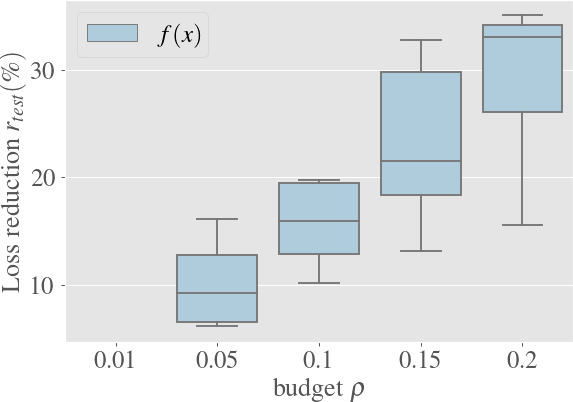

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax, palette=pal)
ax.set_xlabel(r'budget $\rho$')
ax.set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax.legend(loc='upper left')
# pal = sns.color_palette('BuGn_r')
# sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
# ax[1].set_xlabel(r'budget $\rho$')
# ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fx = "drive/My Drive/NIPS2020/results/redwinequality/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fx, bbox_inches='tight', facecolor='w')